# Predicting embryonic phenotypes of genetically modified zebrafish

In this tutorial, we predict perturbations on embryo-scale. Therefore, we consider [ZSCAPE](https://www.nature.com/articles/s41586-023-06720-2), which captures up to 23 perturbations at 5 different time points, resulting in 71 perturbed phenotypes. The experimental design is sparse, hence we investigate to what extent we can fill missing measurements with {class}`~cellflow.model.CellFlow`'s predictions.

## Preliminaries

The dataset is relatively large, hence we use [rapids-single-cell](https://rapids-singlecell.readthedocs.io/en/latest/index.html) which allows us to leverage GPU acceleration for preprocessing and downstream tasks. This notebook is executed on a A100 GPU with 80GB memory, as well as 500GB CPU memory. 

In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import rapids_singlecell as rsc
import flax.linen as nn
import optax
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca, reconstruct_pca
from cellflow.metrics import compute_r_squared, compute_e_distance


/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
adata = cellflow.datasets.zesta()

Let's have a look at the most relevant columns:
- {attr}`obs['timepoint'] <anndata.AnnData.obs>` the age of the embryo in hours post fertilization, as this covers a range from 18 to 72, we have created a columns `"logtime"` which stores the natural logarithm of `"timepoint"`. 
- {attr}`obs['gene1+gene2'] <anndata.AnnData.obs>` contains the genetic perturbation, which can be a single or a double genetic knockout. CellFlow requires as many {attr}`obs <anndata.AnnData.obs>` columns as the largest combination, which is 2 in our case. Hence, we created {attr}`obs['gene_target_1'] <anndata.AnnData.obs>` and {attr}`obs['gene_target_2'] <anndata.AnnData.obs>` which contain the single elements of the perturbation. Control cells have entries `"control"` in both columns, while single perturbations have `"control"` in {attr}`obs['gene_target_2'] <anndata.AnnData.obs>`.
- While not necessary for training CellFlow, it is handy to have {attr}`obs['condition'] <anndata.AnnData.obs>`, which contains the combination of the genetic perturbation and the time point.
- {attr}`obs['is_control'] <anndata.AnnData.obs>` indicates whether a cell is a control cell. Note that we also have {attr}`obs['first_t_control'] <anndata.AnnData.obs>`, which we don't need for the purpose for this notebook, but for {doc}`201_zebrafish_continuous`.

In [3]:
adata.obs.head()

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,hash_plate,log.hash_umis,gene1+gene2,gene_target_1,gene_target_2,condition,is_control,first_t_control,logtime,germ_layer_adapted
A03_B01_P01-A01_LIG104,A03_B01_P01-A01_LIG104,0.766072,348.0,4.022989,18.0,18h_ctrl-inj_P13_H1,29.0,25.803177,head mesenchyme/PA cartilage,head mesenchyme/PA cartilage,...,NA,NaN,control+negative,control,control,control_control_18,True,True,2.890372,mesoderm_neural_crest
A03_B01_P01-A02_LIG101,A03_B01_P01-A02_LIG101,1.001617,455.0,9.010989,72.0,72h_ctrl-inj_P10_A6,46.0,5.384193,intestine (mid),intestine,...,NA,NaN,control+negative,control,control,control_control_72,True,False,4.276666,endoderm
A03_B01_P01-A02_LIG127,A03_B01_P01-A02_LIG127,2.007637,912.0,1.644737,36.0,36h_ctrl-inj_P7_A8,15.0,9.082616,basal cell (early),basal cell,...,NA,NaN,control+negative,control,control,control_control_36,True,False,3.583519,ectoderm_neural_crest
A03_B01_P01-A02_LIG257,A03_B01_P01-A02_LIG257,0.468889,213.0,0.938967,18.0,18h_ctrl-noto_P3_D7,24.0,21.347128,neural progenitor (hindbrain R7/8),neural progenitor (hindbrain R7/8),...,NA,NaN,control+negative,control,control,control_control_18,True,True,2.890372,ectoderm_neural_crest
A03_B01_P01-A03_LIG201,A03_B01_P01-A03_LIG201,0.537131,244.0,0.409836,48.0,48h_ctrl-noto_P16_H9,10.0,6.059433,"neurons (differentiating, contains peripheral)","neurons (differentiating, contains peripheral)",...,NA,NaN,control+negative,control,control,control_control_48,True,False,3.871201,ectoderm_neural_crest


We visualize the time point in hours post fertilization, and the genetic perturbation.

[2025-04-09 09:36:34.007] [CUML] [debug] n_neighbors=15
[2025-04-09 09:36:34.012] [CUML] [debug] Calling knn graph run
[2025-04-09 09:36:34.012] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-04-09 09:36:34.311] [CUML] [debug] Done. Calling remove zeros


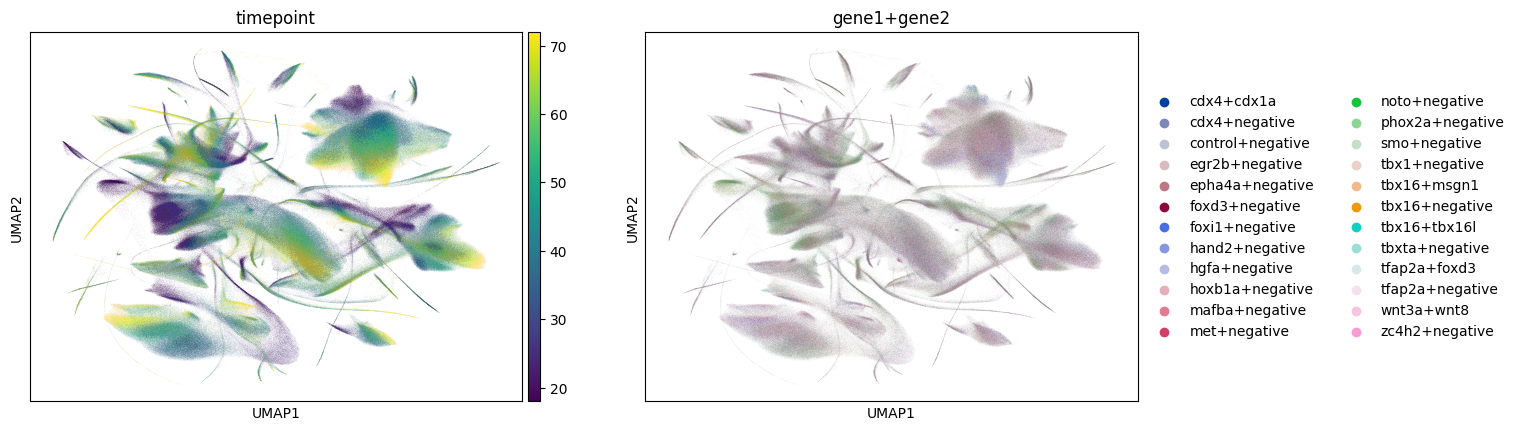

In [4]:
rsc.pp.neighbors(adata, use_rep="X_pca")
rsc.tl.umap(adata)
sc.pl.umap(adata, color=["timepoint", "gene1+gene2"])

Similarly to the use case in the CellFlow manuscript, we aim to predict the phenotype of a cdx4+cdx16 mutant at time point 36, which we first visualize:

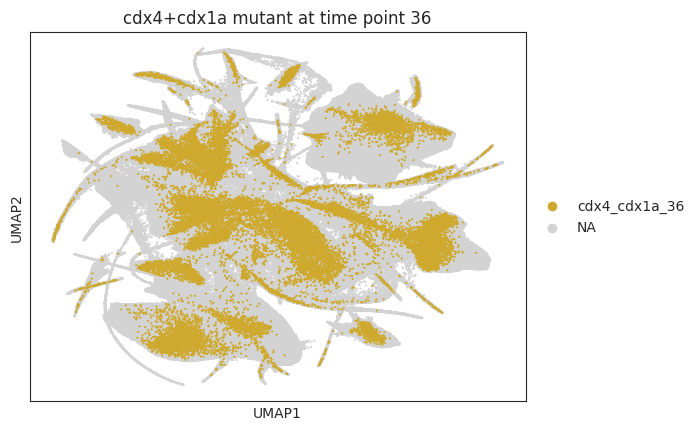

In [21]:
custom_palette = {k: "#D6D6D6" for k in adata.obs["condition"].unique()}
custom_palette.update({"cdx4_cdx1a_36": "#CEA92D"})
order = list(adata[adata.obs["condition"] != "cdx4_cdx1a_36"].obs_names) + \
        list(adata[adata.obs["condition"] == "cdx4_cdx1a_36"].obs_names)

sc.pl.umap(
    adata[order],
    color="condition",
    groups=["cdx4_cdx1a_36"],
    palette=custom_palette,
    title="cdx4+cdx1a mutant at time point 36",
    size=10,
)


We split the data accordingly. Note that we need the control state at time point 36 also in the test data, to be able to translate these to their perturbed state.

In [6]:
adata_train = adata[adata.obs["condition"]!="cdx4_cdx1a_36"].copy()
adata_test = adata[(adata.obs["condition"]=="cdx4_cdx1a_36") | (adata.obs["condition"]=="control_control_36")].copy()
adata_train.n_obs, adata_test.n_obs

(2660905, 184343)

We use {attr}`obsm['X_aligned'] <anndata.AnnData.obsm>` as cellular representation, i.e. this is the space in which cells are generated. We note that the embedding was obtained from control cells only, with perturbed cells regressed onto it *independently* of other perturbed cells, such that we don't have any data leakage from the test dataset. For details on the embedding, please refer to the [ZSCAPE manuscript](https://www.nature.com/articles/s41586-023-06720-2).

## Setting up the CellFlow model

We are now ready to setup the {class}`~cellflow.model.CellFlow` model.

Therefore, we first choose the flow matching solver. We select the default solver `"otfm"`.

In [7]:
cf = CellFlow(adata_train, solver="otfm")

## Preparing {class}`~cellflow.model.CellFlow`'s data handling with {meth}`~cellflow.model.CellFlow.prepare_data`

- As discussed above, we use {attr}`obsm['X_aligned'] <anndata.AnnData.obsm>` as cellular representation.
- {attr}`obs['is_control'] <anndata.AnnData.obs>` indicates whether a cell is a control cell.
- `perturbation_covariates` indicates the external intervention, which is the genetic perturbation. As we also have combinations thereof, we pass the column names `"gene_target_1"` and `"gene_target_2"`. We call this intervention `"genetic_perturbation"`. We use ESM2 embeddings for representing the cytokines, which we have precomputed already for the purpose of this notebook, saved in {attr}`uns['gene_embeddings'] <anndata.AnnData.uns>`. Thus, we pass the information that `"gene_embeddings"` stores embeddings of the {attr}`obs['cytokine'] <anndata.AnnData.obs>` treatments via `perturbation_covariate_reps`.
- The sample covariate describes the cellular context independent of the perturbation. We pass the time point via {attr}`obs['logtime'] <anndata.AnnData.obs>`. 
- The `split_covariates` defines classes within which me map. As we want to learn maps from control to perturbed states *within* the same time point, we set `"timepoint"` to be the split covariate. See {doc}`201_zebrafish_continuous` for a different use of `split_covariates`.
-  `max_combination_length` is the maximum number of gene knockouts seen during training or inference. We set it to `2`. Note that this value is also automatically inferred from the maximum number of elements seen in `perturbation_covariates`, but can optionally set to be higher for inference.
-  The `null_value` is the value which fills the absence of a perturbation, i.e. the value which fills all positions in {attr}`uns['gene_embeddings']['control'] <anndata.AnnData.uns>`. 

In [8]:
cf.prepare_data(
    sample_rep = "X_aligned",
    control_key = "is_control",
    perturbation_covariates = {"genetic_perturbation": ("gene_target_1" , "gene_target_2")},
    perturbation_covariate_reps = {"genetic_perturbation": "gene_embeddings"},
    sample_covariates = ("logtime",),
    split_covariates = ["timepoint"],
    max_combination_length = 2,
    null_value = 0.0,
)

100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


We now prepare the data validation data using {meth}`~cellflow.model.CellFlow.prepare_validation_data`. 

As for some conditions, and in particular for control cells, we have a large number of measurements, we subsample for inference to be faster. However, due to the heterogeneity of the cellular distribution, covering hundreds of cell types, we should not subsample by too much.

In [9]:
adatas_train_subsampled = []
for cond in adata_train.obs["condition"].unique():
    adata_tmp = adata_train[adata_train.obs["condition"]==cond]
    adatas_train_subsampled.append(sc.pp.subsample(adata_tmp, n_obs=min(adata_tmp.n_obs, 10000), copy=True))

adata_train_for_validation = ad.concat(adatas_train_subsampled)

adatas_test_subsampled = []
for cond in adata_test.obs["condition"].unique():
    adata_tmp = adata_test[adata_test.obs["condition"]==cond]
    adatas_test_subsampled.append(sc.pp.subsample(adata_tmp, n_obs=min(adata_tmp.n_obs, 10000), copy=True))

adata_test_for_validation = ad.concat(adatas_test_subsampled)


As we require the embeddings for evaluation as well, we need to copy {attr}`adata <anndata.AnnData.uns>` 

In [10]:
adata_train_for_validation.uns = adata_train.uns.copy()
adata_test_for_validation.uns = adata_test.uns.copy()

cf.prepare_validation_data(
    adata_train_for_validation,
    name="train",
    n_conditions_on_log_iteration=10,
    n_conditions_on_train_end=10,
)

cf.prepare_validation_data(
    adata_test_for_validation,
    name="test",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

100%|██████████| 2/2 [00:00<00:00, 237.19it/s]


## Preparing {class}`~cellflow.model.CellFlow`'s model architecture with {meth}`~cellflow.model.CellFlow.prepare_model`

We are now ready to specify the architecture of {class}`~cellflow.model.CellFlow`.

We only consider the most relevant parameters, for a detailed description, please have a look at the documentation of {meth}`~cellflow.model.CellFlow.prepare_model` or {doc}`100_pbmc`.

- We use `condition_mode="deterministic"` to learn point estimates of condition embeddings, and thus have a fully deterministic mapping. We set `regularization=0.0`, thus don't regularize the learnt latent space. 
- `pooling` defines how we aggregate combinations of conditions in a permutation-invariant manner,  which we choose to do learning a class token indicated by `"attention_token"`.
- With `layers_before_pool` we define how to embed the ESM2 embeddings and the log-value of the time. We process them such that have the same scale of dimensionality.
- `condition_embedding_dim` is the dimension of the latent space of the condition encoder.
- `cond_output_dropout` is the dropout applied to the condition embedding, we recommend to set it relatively high, especially if the `condition_embedding_dim` is large.
- `pool_sample_covariates` defines whether the concatenation of the sample covariates should happen before or after pooling, in our case indicating whether it's part of the self-attention or only appended afterwards. 
- `flow` defines the reference vector field between pairs of samples which the {class}`~cellflow.networks._velocity_field.ConditionalVelocityField` is regressed against. Here, we use `{"constant_noise": 0.5}`, i.e. we use a relatively small value as we have a highly heterogeneous cell population. In fact, if we augment a cell with noise, we should be careful not to augment it to the extent that it is e.g. in a completely different organ of the zebrafish.
- `match_fn` defines how to sample pairs between the control and the perturbed cells. As we have a strongly heterogeneous population, we choose a higher batch size of 2048. We don't expect large outliers, and are not interested in the trajectory of a single cell, hence we choose `tau_a=tau_b=1.0`.

We start with defining the `layers_before_pool` and `layers_after_pool`. 

In [11]:
layers_before_pool = {
    "genetic_perturbation": {"layer_type": "mlp", "dims": [512, 512], "dropout_rate": 0.0},
    "logtime": {"layer_type": "mlp", "dims": [512, 512], "dropout_rate": 0.0},
}

layers_after_pool = {
    "layer_type": "mlp", "dims": [1024, 1024], "dropout_rate": 0.0,
}

We now also explicitly define the `match_fn`:

In [12]:
match_fn = functools.partial(match_linear, epsilon=0.5, tau_a=1.0, tau_b=1.0)

Now we are ready to prepare the model:

In [13]:
cf.prepare_model(
    encode_conditions=True,
    condition_mode="deterministic",
    regularization=0.0,
    pooling="attention_token",
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    condition_embedding_dim=256,
    cond_output_dropout=0.9,
    hidden_dims=[2048, 2048, 2048],
    decoder_dims=[4096, 4096, 4096],
    flow={"constant_noise": 0.5},
    match_fn=match_fn,
    )

## Computing and logging metrics during training 



We compute the energy distance and MMD during training. 

In [15]:
metrics_callback = cellflow.training.Metrics(metrics=["mmd", "e_distance"])
callbacks = [metrics_callback]


## Training CellFlow

Finally, we are ready to train our model. We set the number of iterations relatively high as we have a strongly heterogeneous population. 

In [16]:
cf.train(
        num_iterations=500_000,
        batch_size=2048,
        callbacks=callbacks,
        valid_freq=80_000,
    )

100%|██████████| 500000/500000 [4:25:16<00:00, 31.41it/s, loss=4.86]     


We can now investigate some training statistics, stored by the {class}`~cellflow.training.CellFlowTrainer`.

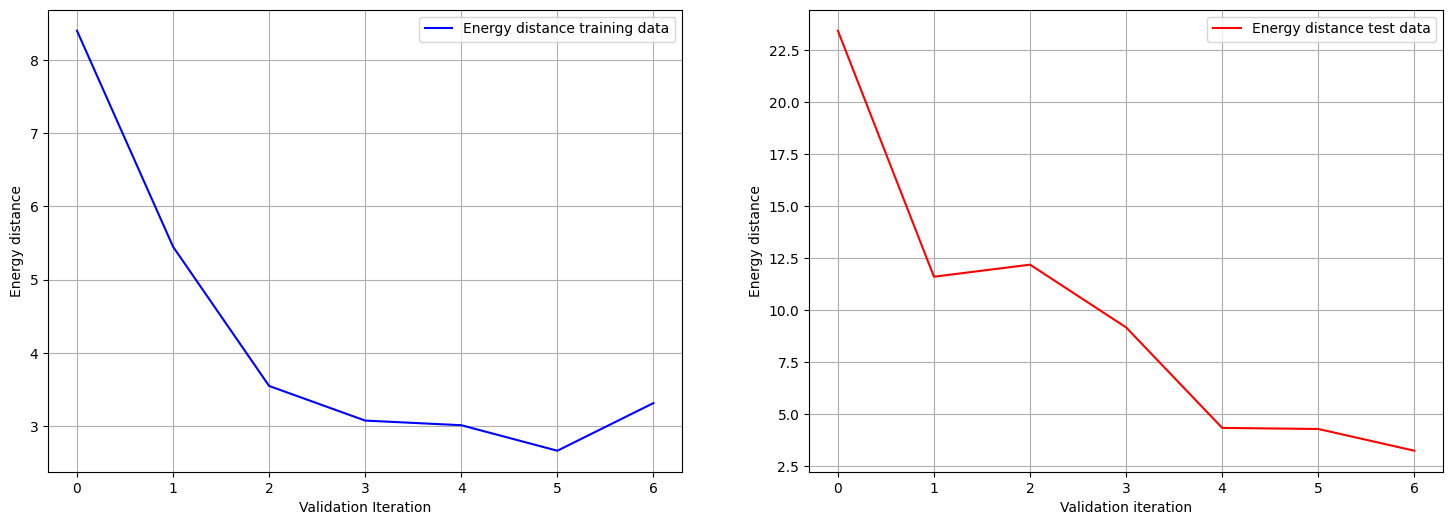

In [17]:
e_distances_train = cf.trainer.training_logs["train_e_distance_mean"]
e_distances_test = cf.trainer.training_logs["test_e_distance_mean"]

iterations_train = np.arange(len(e_distances_train))
iterations_test  = np.arange(len(e_distances_test))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(iterations_train, e_distances_train, linestyle='-', color='blue', label='Energy distance training data')
axes[0].set_xlabel('Validation Iteration')
axes[0].set_ylabel('Energy distance')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(iterations_test, e_distances_test, linestyle='-', color='red', label='Energy distance test data')
axes[1].set_xlabel('Validation iteration')
axes[1].set_ylabel('Energy distance')
axes[1].legend()
axes[1].grid(True)


## Investigating the learnt latent space

We can visualize the learnt latent space for using {meth}`~CellFlow.get_condition_embedding`. 

In [19]:
covariate_data_train = adata_train[~adata_train.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])

df_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_train, condition_id_key="condition", rep_dict=adata_train.uns)[0]
df_embedding_test = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)[0]

df_embedding_train["seen_during_training"] = True
df_embedding_test["seen_during_training"] = False
df_condition_embedding = pd.concat((df_embedding_train, df_embedding_test))


100%|██████████| 1/1 [00:00<00:00, 516.67it/s]


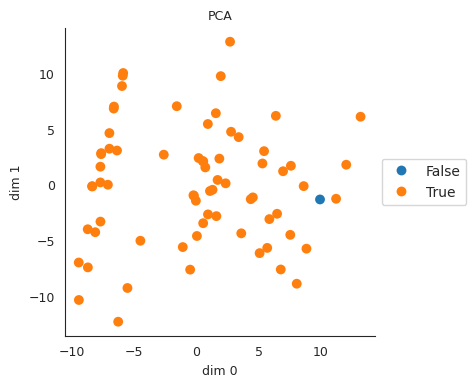

In [20]:
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="seen_during_training", circle_size=50)

Now we can colorize it according to time point and genetic perturbation

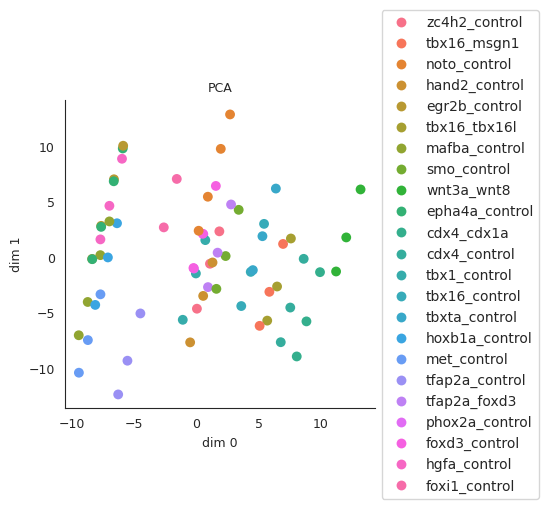

In [22]:
df_condition_embedding["condition"] = df_condition_embedding.index
df_condition_embedding["genetic_perturbation"] = df_condition_embedding.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="genetic_perturbation", circle_size=50)

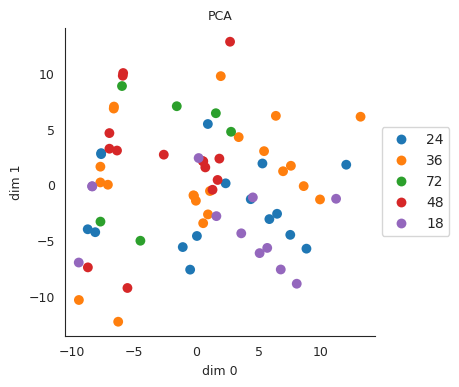

In [23]:
df_condition_embedding["time_point"] = df_condition_embedding.apply(lambda x: x["condition"].split("_")[-1], axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="time_point", circle_size=50, legend=False)


## Predicting with CellFlow

Predictions with {class}`~cellflow.model.CellFlow` require an {class}`adata <anndata.AnnData>` object with control cells. As we only want to generate cells corresponding the unseen perturbation cdx4 and cdx1a, we only need control cells for time point 36. Moreover, we require `covariate_data` to store the information about what we would like to predict. 

In [24]:
adata_ctrl_for_prediction = adata_test[(adata_test.obs["is_control"].to_numpy()) & (adata_test.obs["timepoint"]==36)]
covariate_data = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,hash_plate,log.hash_umis,gene1+gene2,gene_target_1,gene_target_2,condition,is_control,first_t_control,logtime,germ_layer_adapted
A03_B01_P01-A02_LIG135,A03_B01_P01-A02_LIG135,3.180959,1445.0,16.33218,36.0,36h_cdx4-cdx1a_P2_G7,31949.0,inf,mature slow muscle 3,mature slow muscle,...,P2,4.504457,cdx4+cdx1a,cdx4,cdx1a,cdx4_cdx1a_36,False,False,3.583519,mesoderm_neural_crest


We specify `sample_rep` to be `"X_aligned"`, and provide a `condition_id_key` which defines the keys of the returned dictionary containing the predictions.

In [25]:
preds = cf.predict(adata=adata_ctrl_for_prediction, sample_rep="X_aligned", condition_id_key="condition", covariate_data=covariate_data)

100%|██████████| 1/1 [00:00<00:00, 386.22it/s]


We now build an {class}`adata <anndata.AnnData>` object to store the predictions in {attr}`adata.obsm <anndata.AnnData.obsm>`:

In [26]:
adata_preds = []
for cond, array in preds.items():
    
    obs_data = pd.DataFrame({
        'condition': [cond] * array.shape[0]
    })
    adata_pred = ad.AnnData(X=np.empty((len(array),adata_train.n_vars)), obs=obs_data)
    adata_pred.obsm["X_aligned"] = np.squeeze(array)
    adata_preds.append(adata_pred)

adata_preds = ad.concat(adata_preds)
adata_preds.var_names = adata_train.var_names

We now transfer labels using the 1NN classifier based on the training data. Therefore, we first have to compute a nearest neighbor graph, and then transfer the labels subsequently.

In [28]:
compute_wknn(ref_adata=adata_train, query_adata=adata_preds, n_neighbors=1, ref_rep_key="X_aligned", query_rep_key="X_aligned")
transfer_labels(query_adata=adata_preds, ref_adata=adata_train, label_key="cell_type_broad")

In [34]:
adata_preds.obs["mode"] = "generated"
adata_train.obs["mode"] = "train"
adata_test.obs["mode"] = "test"

adata_concatenated = ad.concat((adata_preds, adata_train, adata_test[~adata_test.obs["is_control"].to_numpy()]))

rsc.pp.neighbors(adata_concatenated, use_rep="X_aligned")
rsc.tl.umap(adata_concatenated)


[2025-04-09 21:32:05.988] [CUML] [debug] n_neighbors=15
[2025-04-09 21:32:05.992] [CUML] [debug] Calling knn graph run
[2025-04-09 21:32:05.992] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-04-09 21:32:06.062] [CUML] [debug] Done. Calling remove zeros


For a visual assessment, we compare true cells with generated cells on a UMAP

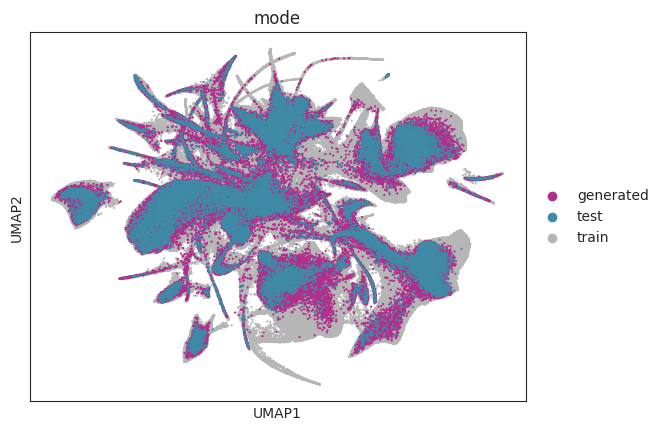

In [36]:
adata_concatenated.obs["condition_mode"] = adata_concatenated.obs.apply(lambda x: x["condition"] + "_" + x["mode"], axis=1)
adata_concatenated.obs.reset_index(inplace=True)

color_palette = {"generated": "#B12F8C", "test": "#3F8AA6", "train": "#B6B6B6"}
order = list(adata_concatenated[adata_concatenated.obs["mode"]=="train"].obs_names) + list(adata_concatenated[adata_concatenated.obs["mode"]=="generated"].obs_names) + list(adata_concatenated[adata_concatenated.obs["mode"]=="test"].obs_names)
sc.pl.umap(adata_concatenated[order], color=["mode"], palette=color_palette, size=10)